# Convolutional Variational Autoencoder

The goal of this notebook is to show how to train a Variational Autoencoder (VAE) ([1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082)) model on the Indonesia SFINCS runs dataset (generated in by the `prepare/prepare.ipynb` notebook). It is based on the [CVAE notebook](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb) from [tensorflow](https://www.tensorflow.org/tutorials/generative/cvae). A VAE is a probabilistic take on the autoencoder. An autoencoder a model that uses dimension reduction to represent higher dimensional and spaced data into a latent vector space, similar to other dimensionality reduction techniques like PCA. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and a standard deviation. This approach can also generate data that is variable.
In our example rain will not always lead to a flooding event, but sometimes. This variation is also taken into account in this model.

## Setup

In [1]:
import glob
import time

import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import sklearn.preprocessing
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import backend as K
import xarray as xr
from IPython import display

## Load the Indonesia dataset
Each example is composed of a a number of input variables and an expected flood map. 

In [2]:
# open the training examples
batch_size = 16
train_size = 12 * batch_size
shuffle_size = 32


ds_full = xr.open_zarr("../prepare/test-training.zarr")
# ds = ds_full.sel(example=np.arange(0, train_size))
ds = ds_full

In [3]:
img_shape = (128, 128)

In [4]:
ranges = {}
for var in ds.variables:
    ranges[var] = [
        ds.variables[var].min().values.item(),
        ds.variables[var].max().values.item(),
    ]
    if var in ('flood_depth', 'flood_hand'):
        ranges[var][0] = 0
ranges

{'M_slices': [0, 1919],
 'M_start_stop': [0, 1919],
 'N_slices': [0, 1919],
 'N_start_stop': [0, 1919],
 'distance_to_river': [0.0, 10263.1015625],
 'elevation': [-3.0179998874664307, 2030.858642578125],
 'example': [0, 5999],
 'flood_depth': [0, 6.927290439605713],
 'flood_hand': [0, 0.7437315583229065],
 'flowdir_cosine_y': [-1.0, 1.0],
 'flowdir_sine_y': [-1.0, 1.0],
 'is_flooded': [False, True],
 'is_permanent_water': [0.0, 1.0],
 'manning_values': [0.0, 0.11999999731779099],
 'mask': [0.0, 1.0],
 'minmax': [0, 1],
 'slope': [0.0, 1.1036791801452637],
 'soil_moisture': [0.0, 255.0],
 'uparea_idw': [0.0, 218.2404022216797],
 'x': [0, 127],
 'y': [0, 127]}

In [5]:
tensors = pd.read_json("../prepare/tensors.json")
inputs = list(tensors.query("role == 'input'")["name"].values)
outputs = list(tensors.query("role == 'output'")["name"].values)
num_channels = len(inputs)
inputs

['soil_moisture',
 'flood_hand',
 'elevation',
 'uparea_idw',
 'slope',
 'manning_values',
 'distance_to_river',
 'flowdir_sine_y',
 'flowdir_cosine_y',
 'is_permanent_water',
 'mask']

In [6]:
tensors

,name,var,shape,dtype,dims,role,min,max
0,soil_moisture,cn_avg,"[128, 128]",float32,"[x, y]",input,0,1
1,flood_hand,floodmaps_gis,"[128, 128]",float32,"[x, y]",input,0,1
2,elevation,elevation_subsidence,"[128, 128]",float32,"[x, y]",input,0,100
3,uparea_idw,uparea_idw,"[128, 128]",float32,"[x, y]",input,0,200
4,slope,slope,"[128, 128]",float32,"[x, y]",input,0,1
5,manning_values,manning_values,"[128, 128]",float32,"[x, y]",input,0,200
6,distance_to_river,distance_to_river,"[128, 128]",float32,"[x, y]",input,0,40000
7,flowdir_sine_y,flowdir_sine_y,"[128, 128]",float32,"[x, y]",input,-1,1
8,flowdir_cosine_y,flowdir_cosine_y,"[128, 128]",float32,"[x, y]",input,-1,1
9,is_permanent_water,permanent_water_p75,"[128, 128]",bool,"[x, y]",input,0,1


# Convert the netcdf's to tensors.
Here we convert and scale our data to a data structure that tensorflow understands. See this [tutorial](https://www.noahbrenowitz.com/post/loading_netcdfs/) for a nice introduction 

In [7]:
# tf.convert_to_tensor(ds["a"])
tensor_data = {}
for i, row in tensors.iterrows():
    # floats only
    arr = ds[row["name"]].values.astype("float32")
    # compute to 0-1
    min_i, max_i = ranges[row["name"]]
    arr = (arr - min_i) / (max_i - min_i)
    # store scaled date
    tensor_data[row["name"]] = tf.convert_to_tensor(arr)

2024-03-12 14:30:45.476627: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-03-12 14:30:45.476653: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-03-12 14:30:45.476660: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-03-12 14:30:45.477119: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-12 14:30:45.477520: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
tf_ds = tf.data.Dataset.from_tensor_slices(tensor_data)

In [9]:
def postprocess_example(example):
    def replace_nan(t):
        """replace nans with 0"""
        return tf.where(tf.math.is_nan(t), tf.zeros_like(t), t)
    nan_treatment = {
        "flood_hand": replace_nan,
        "slope": replace_nan,
        "manning_values": replace_nan
    }
    for key, example_i in example.items():
        example_i = replace_nan(example_i)
        min, max = ranges[key]
        scaled_example_i = (example_i - min) / (max - min)
        example[key] = scaled_example_i
        
    return example

In [10]:
def generate_xy(example):
    # example = list(batch_example)[0]
    x = tf.concat([example[x][..., np.newaxis] for x in inputs], axis=-1)
    y = example[outputs[1]][..., np.newaxis]
    mask = example["mask"][..., np.newaxis]
    y = tf.concat([y, mask], axis=-1)
    return x, y 

In [11]:
ds_i = ds_full.sel(example=i)


In [12]:
def generate_examples():
    for i in ds_full.example:
        ds_i = ds_full.sel(example=i)
        # nothing flooded, no need to train
        
        if (~np.isnan(ds_i['flood_depth'].values)).sum() < 100:
            continue
            
        tensor_data = {}
        for i, row in tensors.iterrows():
            # floats only
            arr = ds_i[row["name"]].values.astype("float32")
            # store scaled date
            tensor_data[row["name"]] = tf.convert_to_tensor(arr)    

        
        
        example_i = postprocess_example(tensor_data)

        n_flooded = (example_i['flood_depth'] > 0).numpy().sum()
        if n_flooded < 100:
            continue
    
        x_i, y_i = generate_xy(example_i)
        yield x_i, y_i
x_spec = tf.TensorSpec(shape=(img_shape[0], img_shape[1], num_channels), dtype=tf.float32, name='x')
y_spec = tf.TensorSpec(shape=(img_shape[0], img_shape[1], 2), dtype=tf.float32, name='y')
train_dataset = tf.data.Dataset.from_generator(generate_examples, output_signature=(x_spec, y_spec))


## Use *tf.data* to batch and shuffle the data

In [13]:

# train_dataset = tf_ds.shuffle(train_size).batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

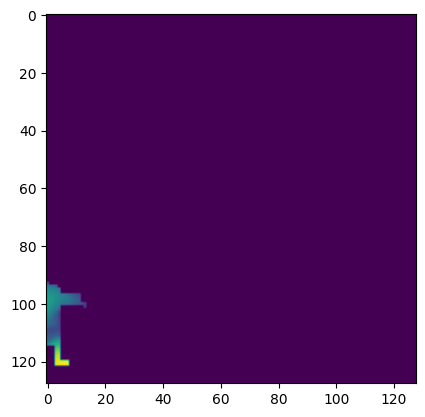

In [14]:
batch_example = train_dataset.take(1)
example_x, example_y = list(batch_example)[0]
plt.imshow(example_y[0, ..., 0])

## Define the encoder and decoder networks with *tf.keras.Sequential*

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. 
Output log-variance instead of the variance directly for numerical stability.

### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.


In [15]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, img_shape, latent_dim, num_channels, batch_size):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_channels = num_channels
        self.batch_size = batch_size
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(
                    input_shape=(img_shape[0], img_shape[1], num_channels),
                    batch_size=batch_size,
                ),
                tf.keras.layers.Conv2D(
                    padding="same",
                    filters=32, kernel_size=3, strides=(2, 2), activation="relu"
                ),
                # consider max pooling, here?
                tf.keras.layers.Conv2D(
                    padding="same",
                    filters=64, kernel_size=3, strides=(2, 2), activation="relu"
                ),
                tf.keras.layers.Flatten(),
                # No activation
                # tf.keras.layers.Dense(latent_dim + latent_dim),
                tf.keras.layers.Dense(latent_dim ),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                # why 32
                tf.keras.layers.Dense(
                    units=img_shape[0] // 4 * img_shape[1] // 4 * 32,
                    activation=tf.nn.relu,
                ),
                tf.keras.layers.Reshape(
                    target_shape=(img_shape[0] // 4, img_shape[1] // 4, 32)
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=2,
                    padding="same",
                    activation="relu",
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=2,
                    padding="same",
                    activation="relu",
                ),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding="same"
                ),
            ]
        )

    def reparameterize(self, mean, logvar):
        
        eps = tf.random.normal(shape=(self.batch_size, self.latent_dim))
        return eps * tf.exp(logvar * .5) + mean

    def split(self, encoded):
        mean, logvar = tf.split(encoded, num_or_size_splits=2, axis=1)
        return mean, logvar  

    
    def call(self, x):
        encoded = self.encoder(x)

        # without this part it's just a normal CNN
        # reparameterization trick
        # mean, logvar = self.split(encoded)
        # random normal distribution + whatever....
        # parameterized = self.reparameterize(mean, logvar)
        
        decoded = self.decoder(encoded)
        return decoded

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

Note: You could also analytically compute the KL term, but here you incorporate all three terms in the Monte Carlo estimator for simplicity.

In [16]:
def loss(true, pred):
    # get last channel as mask
    mask = true[..., -1]
    mask = mask[..., tf.newaxis]

    # the first channel is the true flood level
    true = true[..., 0]
    true = true[..., tf.newaxis]

    # compute the squared error
    error = K.square(true - pred)
    # replace non masked values (mask==0) with error, masked areas with 0
    error = tf.where(K.less_equal(mask, 0.5), error, tf.zeros_like(error))

    error = K.mean(error)

    return error


In [17]:
model = CVAE(img_shape=img_shape, latent_dim=100, num_channels=num_channels, batch_size=batch_size)
model.compile(optimizer="adam", loss=loss)
input_shape = tf.TensorShape([None, img_shape[0], img_shape[1], num_channels])
model.build(input_shape=input_shape)

In [18]:
model.fit(train_dataset.repeat(), steps_per_epoch=32, epochs=20)

Epoch 1/20


2024-03-07 10:55:04.852224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2453s 79s/step - loss: 1.7599e-06
Epoch 2/20
32/32 [==============================] - 1321s 23s/step - loss: 1.5784e-06
Epoch 3/20
32/32 [==============================] - 537s 17s/step - loss: 1.4586e-06
Epoch 4/20
32/32 [==============================] - 5270s 169s/step - loss: 2.0803e-06
Epoch 5/20
32/32 [==============================] - 1317s 42s/step - loss: 1.5574e-06
Epoch 6/20
32/32 [==============================] - 1087s 35s/step - loss: 1.5638e-06
Epoch 7/20
32/32 [==============================] - 676s 21s/step - loss: 1.9926e-06
Epoch 8/20
32/32 [==============================] - 618s 19s/step - loss: 1.6682e-06
Epoch 9/20
32/32 [==============================] - 624s 20s/step - loss: 1.5187e-06
Epoch 10/20
32/32 [==============================] - 599s 19s/step - loss: 1.5026e-06
Epoch 11/20
32/32 [==============================] - 643s 20s/step - loss: 2.1078e-06
Epoch 12/20
32/32 [==============================] - 537s 17s/step -

In [26]:
model.encoder.summary()
model.decoder.summary()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (16, 64, 64, 32)          3200      
                                                                 
 conv2d_1 (Conv2D)           (16, 32, 32, 64)          18496     
                                                                 
 flatten (Flatten)           (16, 65536)               0         
                                                                 
 dense (Dense)               (16, 100)                 6553700   
                                                                 
Total params: 6575396 (25.08 MB)
Trainable params: 6575396 (25.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param

In [27]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap="gray")
        plt.axis("off")

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

In [58]:
# Pick a sample of the test set for generating output images
num_examples_to_generate = 16
assert batch_size >= num_examples_to_generate
for test_batch in train_dataset.take(1):
    x, y = test_batch
    test_sample = x[0:num_examples_to_generate, :, :, :]

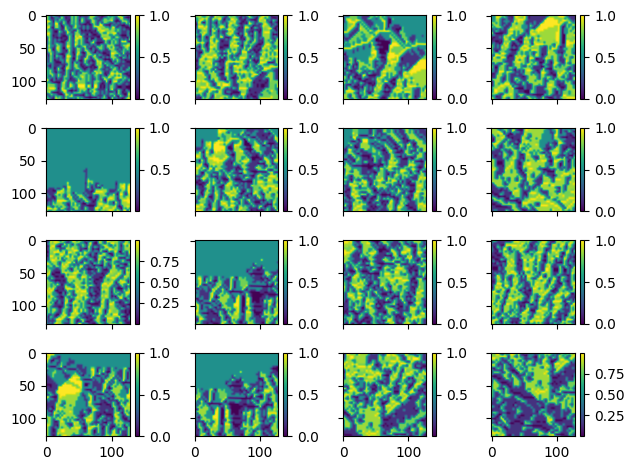

In [59]:
fig, axes = plt.subplots(ncols=4, nrows=4, sharex=True, sharey=True)
for i, (example_i, ax) in enumerate(zip(x, axes.flat)):
    im = ax.imshow(example_i[..., 8])
    plt.colorbar(im, ax=ax)
fig.tight_layout()


<tf.Tensor: shape=(128, 128), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)>

In [64]:
i = 14

import ipywidgets
y_pred = model.predict(test_sample)

@ipywidgets.interact(i=(0, 15))
def plot(i):
    fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(8, 3))
    fig.suptitle(f'Loss {loss(y[i], y_pred[i]).numpy():.2e}')
    axes[0].imshow(y_pred[i])
    axes[0].set_title(f"pred ({y_pred[i, ..., 0].min():.2f} - {y_pred[i, ..., 0].max():.2f})")
    
    axes[1].imshow(y[i, ..., 0])
    axes[1].set_title(f"obs ({y[i, ..., 0].numpy().min():.2f} - {y[i, ..., 0].numpy().max():.2f})")
    im, axes[2].imshow(x[i, ..., 0])
    axes[2].set_title('mask')
    plt.colorbar(im, ax=axes[2])
    im, axes[3].imshow(y[i, ..., -1])
    axes[3].set_title('mask (y[...,-1]')
    plt.colorbar(im, ax=axes[3])
    fig.tight_layout()
    return 



1/1 [==============================] - 0s 15ms/step


interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

In [24]:
generate_and_save_images(model, 0, test_sample)
losses = []
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    losses.append(elbo)
    display.clear_output(wait=False)
    print(
        "Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}".format(
            epoch, elbo, end_time - start_time
        )
    )
    generate_and_save_images(model, epoch, test_sample)

AttributeError: 'CVAE' object has no attribute 'encode'

### Display a generated image from the last training epoch

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open("image_at_epoch_{:04d}.png".format(epoch_no))

In [ ]:
plt.imshow(display_image(epoch))
plt.axis("off")  # Display images

### Display an animated GIF of all the saved images

In [ ]:
anim_file = "cvae.gif"

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob("image*.png")
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed

embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

In [ ]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("Off")
    plt.show()

In [ ]:
plot_latent_images(model, 20)

## Next steps

This tutorial has demonstrated how to implement a convolutional variational autoencoder using TensorFlow. 

As a next step, you could try to improve the model output by increasing the network size. 
For instance, you could try setting the `filter` parameters for each of the `Conv2D` and `Conv2DTranspose` layers to 512. 
Note that in order to generate the final 2D latent image plot, you would need to keep `latent_dim` to 2. Also, the training time would increase as the network size increases.

You could also try implementing a VAE using a different dataset, such as CIFAR-10.

VAEs can be implemented in several different styles and of varying complexity. You can find additional implementations in the following sources:
- [Variational AutoEncoder (keras.io)](https://keras.io/examples/generative/vae/)
- [VAE example from "Writing custom layers and models" guide (tensorflow.org)](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example)
- [TFP Probabilistic Layers: Variational Auto Encoder](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE)

If you'd like to learn more about the details of VAEs, please refer to [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691).